# Using Python to Access NCEI Archived NEXRAD Level 2 Data

This notebook shows how to access the THREDDS Data Server (TDS) instance that is serving up archived NEXRAD Level 2 data hosted on Amazon S3. The TDS provides a mechanism to query for available data files, as well as provides access to the data as native volume files, through OPeNDAP, and using its own CDMRemote protocol. Since we're using Python, we can take advantage of Unidata's Siphon package, which provides an easy API for talking to THREDDS servers.

**NOTE:** Due to data charges, the TDS instance in AWS only allows access to .edu domains. For other users interested in using Siphon to access radar data, you can access recent (2 weeks') data by changing the server URL below to: http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/

**But first!**
Bookmark these resources for when you want to use Siphon later!
+ [latest Siphon documentation](http://siphon.readthedocs.org/en/latest/)
+ [Siphon github repo](https://github.com/Unidata/siphon)
+ [TDS documentation](http://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html)

## Downloading the single latest volume


Just a bit of initial set-up to use inline figures and quiet some warnings.

In [1]:
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)
%matplotlib inline

/Users/marvinbertin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


First we'll create an instance of RadarServer to point to the appropriate radar server access URL.

In [3]:
!pip install siphon

    100% |████████████████████████████████| 327kB 628kB/s 
    100% |████████████████████████████████| 4.7MB 51kB/s 
You are using pip version 8.0.2, however version 8.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/')

Next, we'll create a new query object to help request the data. Using the chaining methods, let's ask for the latest data at the radar KLVX (Louisville, KY). We see that when the query is represented as a string, it shows the encoded URL.

In [3]:
from datetime import datetime, timedelta
query = rs.query()
query.stations('KLVX').time(datetime.utcnow())

time=2016-03-02T06%3A29%3A12.794655&stn=KLVX

We can use the RadarServer instance to check our query, to make sure we have required parameters and that we have chosen valid station(s) and variable(s)


In [4]:
rs.validate_query(query)

True

Make the request, which returns an instance of TDSCatalog; this handles parsing the returned XML information.

In [5]:
catalog = rs.get_catalog(query)

We can look at the datasets on the catalog to see what data we found by the query. We find one volume in the return, since we asked for the volume nearest to a single time.

In [6]:
catalog.datasets

{'Level2_KLVX_20160302_0611.ar2v': <siphon.catalog.Dataset at 0x10c293710>}

We can pull that dataset out of the dictionary and look at the available access URLs. We see URLs for OPeNDAP, CDMRemote, and HTTPServer (direct download).

In [7]:
ds = list(catalog.datasets.values())[0]
ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/nexrad/level2/IDD/KLVX/20160302/Level2_KLVX_20160302_0611.ar2v',
 'HTTPServer': 'http://thredds.ucar.edu/thredds/fileServer/nexrad/level2/IDD/KLVX/20160302/Level2_KLVX_20160302_0611.ar2v',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/nexrad/level2/IDD/KLVX/20160302/Level2_KLVX_20160302_0611.ar2v'}

We'll use the CDMRemote reader in Siphon and pass it the appropriate access URL.

In [8]:
from siphon.cdmr import Dataset

In [9]:
data = Dataset(ds.access_urls['CdmRemote'])

We define some helper functions to make working with the data easier. One takes the raw data and converts it to floating point values with the missing data points appropriately marked. The other helps with converting the polar coordinates (azimuth and range) to Cartesian (x and y).

In [10]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

The CDMRemote reader provides an interface that is almost identical to the usual python NetCDF interface. We pull out the variables we need for azimuth and range, as well as the data itself.

In [11]:
sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

Then convert the raw data to floating point values and the polar coordinates to Cartesian.

In [12]:
ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

MetPy is a Python package for meteorology (Documentation: http://metpy.readthedocs.org and GitHub: http://github.com/MetPy/MetPy). We import MetPy and use it to get the colortable and value mapping information for the NWS Reflectivity data.

In [13]:
from metpy.plots import ctables  # For NWS colortable
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

Finally, we plot them up using matplotlib and cartopy. We create a helper function for making a map to keep things simpler later.

In [14]:
import matplotlib.pyplot as plt
import cartopy

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = cartopy.crs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    # Grab state borders
    state_borders = cartopy.feature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    
    return ax

Use the function to make a new map and plot a colormapped view of the data

/Users/marvinbertin/anaconda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/marvinbertin/anaconda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


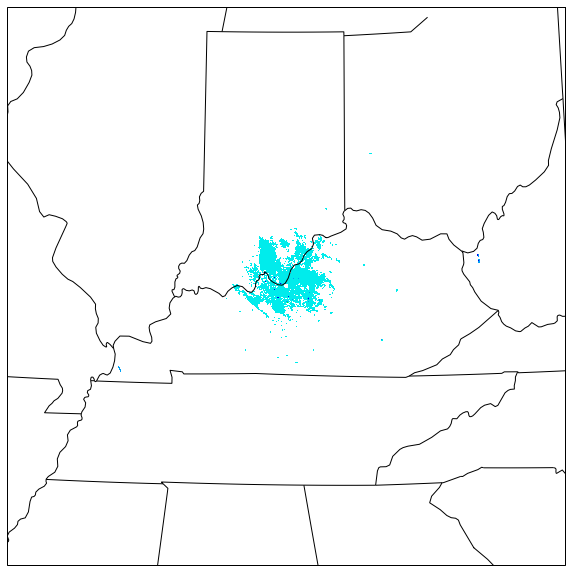

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

## Download a collection of historical data

This time we'll make a query based on a longitude, latitude point and using a time range.

In [101]:
query = rs.query()
dt = datetime(2016, 2, 27, 12) # Our specified time
# San Francisco -121.898, 37.155
query.lonlat_point(-121.898, 37.155).time_range(dt, dt + timedelta(hours=2))

time_start=2016-02-27T12%3A00%3A00&time_end=2016-02-27T14%3A00%3A00&latitude=37.155&longitude=-121.898

The specified longitude, latitude are in NY and the TDS helpfully finds the closest station to that point. The time range we request is an hour of data form 29 October 2012; we're looking for data from Hurricane Sandy. We can see that this time we obtained multiple datasets.

In [102]:
cat = rs.get_catalog(query)
cat.datasets

{'Level2_KMUX_20160227_1201.ar2v': <siphon.catalog.Dataset at 0x120473210>,
 'Level2_KMUX_20160227_1205.ar2v': <siphon.catalog.Dataset at 0x120473310>,
 'Level2_KMUX_20160227_1208.ar2v': <siphon.catalog.Dataset at 0x120473790>,
 'Level2_KMUX_20160227_1212.ar2v': <siphon.catalog.Dataset at 0x12036c650>,
 'Level2_KMUX_20160227_1216.ar2v': <siphon.catalog.Dataset at 0x12036c750>,
 'Level2_KMUX_20160227_1219.ar2v': <siphon.catalog.Dataset at 0x1204731d0>,
 'Level2_KMUX_20160227_1223.ar2v': <siphon.catalog.Dataset at 0x12036c690>,
 'Level2_KMUX_20160227_1227.ar2v': <siphon.catalog.Dataset at 0x12036c790>,
 'Level2_KMUX_20160227_1231.ar2v': <siphon.catalog.Dataset at 0x120473050>,
 'Level2_KMUX_20160227_1234.ar2v': <siphon.catalog.Dataset at 0x1204732d0>,
 'Level2_KMUX_20160227_1238.ar2v': <siphon.catalog.Dataset at 0x120473390>,
 'Level2_KMUX_20160227_1242.ar2v': <siphon.catalog.Dataset at 0x120473290>,
 'Level2_KMUX_20160227_1246.ar2v': <siphon.catalog.Dataset at 0x1204733d0>,
 'Level2_KMU

Grab the first dataset so that we can get the longitude and latitude of the station and make a map for plotting. We'll go ahead and specify some longitude and latitude bounds for the map.

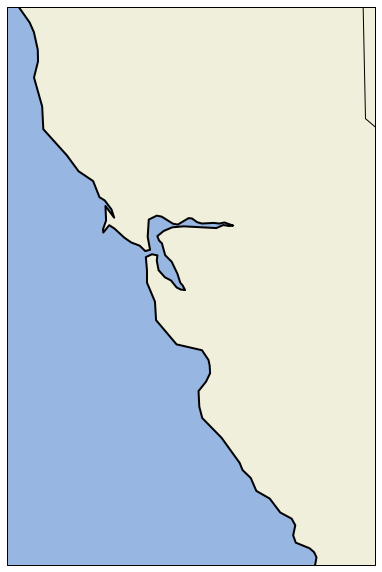

In [120]:
ds = list(cat.datasets.values())[0]
data = Dataset(ds.access_urls['CdmRemote'])
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)

# Set limits in lat/lon space -121.898, 37.155
ax.set_extent([-124, -120, 35, 40])

# Add ocean and land background
ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', scale='50m',
                                            edgecolor='face',
                                            facecolor=cartopy.feature.COLORS['water'])
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='50m',
                                           edgecolor='face',
                                           facecolor=cartopy.feature.COLORS['land'])

ax.add_feature(ocean, zorder=-1)
ax.add_feature(land, zorder=-1)

Now we can loop over the collection of returned datasets and plot them. As we plot, we collect the returned plot objects so that we can use them to make an animated plot. We also add a timestamp for each plot.

In [ ]:
meshes = []
for item in sorted(cat.datasets.items()):
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    ds = item[1]
    data = Dataset(ds.access_urls['CdmRemote'])

    # Pull out the data of interest
    sweep = 0
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref_var = data.variables['Reflectivity_HI']

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.65, 0.03, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))

Using matplotlib, we can take a collection of ``Artists`` that have been plotted and turn them into an animation. With matplotlib 1.5 (1.5-rc2 is available now!), this animation can be converted to HTML5 video viewable in the notebook.

In [ ]:
# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)